#### **Data Processing**

In [275]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
all_results_healthcare_clean = pd.read_csv('healthcare_with_combi_1.csv').set_index('date').drop(columns='Unnamed: 0')
all_results_tech_clean = pd.read_csv('tech_with_combi_1.csv').set_index('date').drop(columns='Unnamed: 0')
all_results_tech_clean

,rolling_alpha_5f,lasso,ridge,xgboost,lgbm,rf,pca,lstm,benchmark_alpha,simple_avg,err_weighted
date,,,,,,,,,,,
2019-03-29,-0.064261,0.011322,0.005189,0.016915,0.013942,0.012832,0.012908,0.013421,0.000000,0.012361,0.012361
2019-03-29,-0.029964,0.014797,0.008808,0.018278,0.013942,0.014267,0.017173,0.017850,0.000000,0.015017,0.014800
2019-03-29,-0.021149,-0.001822,-0.007796,-0.009167,-0.002699,-0.011748,-0.001378,-0.000003,0.000000,-0.004945,-0.006208
2019-03-29,-0.019178,-0.001233,-0.009139,-0.008551,-0.002699,-0.009513,-0.000625,0.001698,0.000000,-0.004295,-0.005596
2019-03-29,-0.017032,-0.000352,-0.003391,-0.008318,-0.002699,-0.006186,-0.000841,-0.002480,0.000000,-0.003467,-0.004080
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,0.045010,0.012207,0.014545,0.020629,0.014624,0.025652,0.014393,0.017015,0.002931,0.017009,0.017802
2024-07-31,0.010018,0.002183,-0.002810,0.005508,0.005679,0.006577,0.003015,-0.001950,0.004697,0.002600,0.004059
2024-07-31,0.010697,0.002353,-0.002306,0.005810,0.005706,0.006999,0.003034,0.001361,0.004697,0.003280,0.004389


In [276]:
# Generation of Error Metrics
def mean_absolute_scaled_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae = mean_absolute_error(y_true, y_pred)
    mase = mae / naive_mae if naive_mae != 0 else np.nan

    return mase 

def metrics_generator(df, metric, outcome_var, relevant_cols):
    if metric == 'MASE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_scaled_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    elif metric == 'MAE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    elif metric == 'R2':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: max(r2_score(group[outcome_var], group[col]), -2) for col in relevant_cols
            })
        )
    elif metric == 'MSE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_squared_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    else:
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: np.sqrt(mean_squared_error(group[outcome_var], group[col])) for col in relevant_cols
            })
        )
    return final_df


all_metrics_results = {metric: {} for metric in ["MASE", "MAE", "R2", "MSE", "RMSE"]}

models = ['ridge', 'rf', 'xgboost', 'pca', 'lgbm', 'lstm', 'benchmark_alpha','simple_avg','err_weighted']
# models = ['ridge', 'rf', 'pca', 'lstm']
    
rmse_healthcare = metrics_generator(all_results_healthcare_clean, metric = "RMSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
rmse_tech = metrics_generator(all_results_tech_clean, metric = "RMSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
# rmse_healthcare

#### **Plots**

Plot 1: Metrics Plot by Time

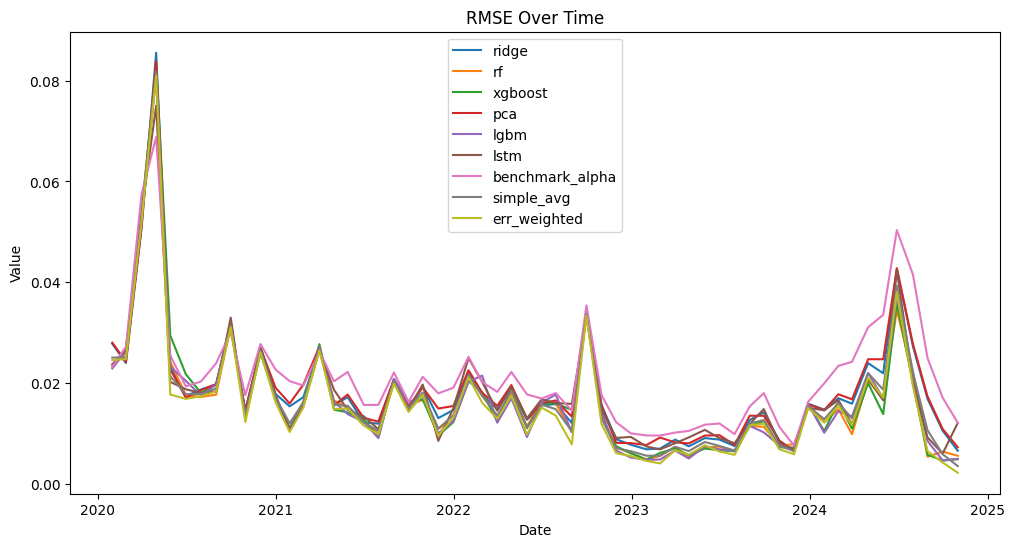

In [277]:
# Single Plot
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming it's already in a DataFrame named df)
rmse_healthcare.index = pd.to_datetime(rmse_healthcare.index)  # Ensure index is datetime

# Plot all models
plt.figure(figsize=(12, 6))
for column in rmse_healthcare.columns:
    plt.plot(rmse_healthcare.index, rmse_healthcare[column], label=column)

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("RMSE Over Time")
plt.legend()
plt.grid(False)
plt.show()

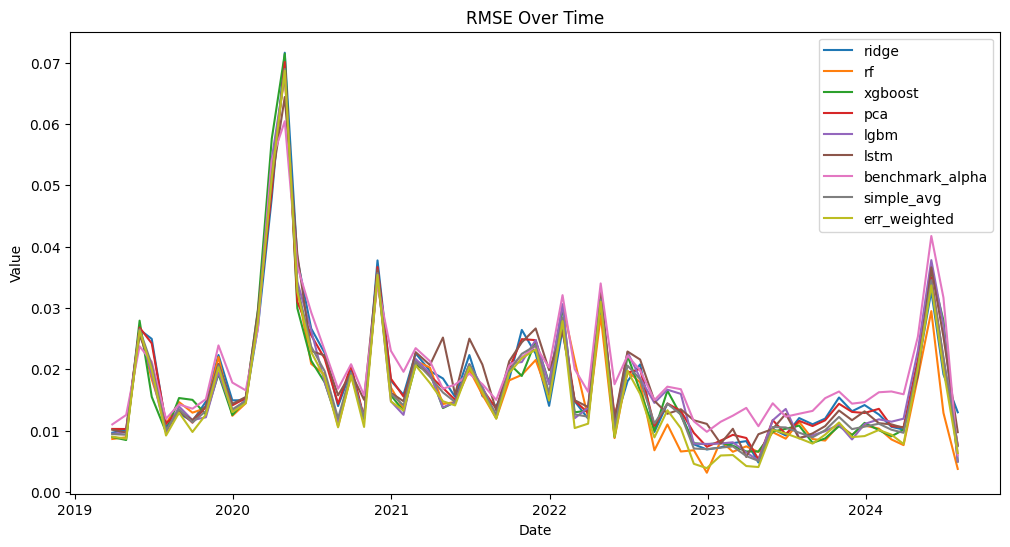

In [278]:
# Single Plot
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming it's already in a DataFrame named df)
rmse_tech.index = pd.to_datetime(rmse_tech.index)  # Ensure index is datetime

# Plot all models
plt.figure(figsize=(12, 6))
for column in rmse_tech.columns:
    plt.plot(rmse_tech.index, rmse_tech[column], label=column)

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("RMSE Over Time")
plt.legend()
plt.grid(False)
plt.show()

Expanding Window Mean Benchmark

In [ ]:
# df_combined_new = df_combined_new.sort_index()
# list_of_dates_unique = df_combined_new.index.unique()
# mean_lst = []
# actual_val = df_combined_new[['rolling_alpha_5f']]
# for i in range(len(list_of_dates_unique)):
#     if i == 0: # First entry
#         mean_val = 0
#         mean_lst.append(mean_val)
#         continue
#     filtered_val = actual_val[actual_val.index < list_of_dates_unique[i]]
#     mean_val = filtered_val['rolling_alpha_5f'].mean()
#     mean_lst.append(mean_val)
# mean_df = pd.DataFrame(
#     {'date' : list_of_dates_unique,
#     'benchmark_alpha' : mean_lst}
# )
# df_combined_new_reset = df_combined_new.reset_index()
# # df_combined_new.index.map(mean_df)
# # df_combined_new
# combined_benchmark = pd.merge(df_combined_new_reset,mean_df,on='date',how='left')
# combined_benchmark = combined_benchmark.set_index('date')
# mean_df

Plot 3: Cumulative Alpha Over Time

In [279]:
def plot_cumulative_alpha(df, outcome_var):
    label_mapping = {'ridge': 'Ridge', 'xgboost': 'XGBoost', 'rf': 'RF', 'pca': 'PCA', 'lasso': 'Lasso', 
                     'lgbm':'LGBM', 'lstm':'LSTM','benchmark_alpha':'Benchmark',
                     'simple_avg':'Simple Average', 'err_weighted':'BG'}
    color_list = {'Ridge': 'purple', 'XGBoost': 'gold', 'PCA': 'lightseagreen', 'RF': 'navy', 'Lasso':'crimson', 
                  'LGBM':'pink', 'LSTM':'green', 'Benchmark':'black',
                  'Simple Average':'darkgreen', 'BG':'brown'}
    
    fig, axis = plt.subplots(figsize=(12, 6))
    legend_handles = {}
    df_to_plot = df.copy()
    df_to_plot.index = pd.to_datetime(df_to_plot.index)
    df_to_plot = df_to_plot.sort_index()
    df_to_plot = df_to_plot.groupby(df_to_plot.index).mean()   # take mean for duplicated dates
    model_cols = [col for col in df_to_plot.columns if col != outcome_var]
    df_to_plot[outcome_var] = (df_to_plot[outcome_var] - df_to_plot[outcome_var].mean()) / df_to_plot[outcome_var].std()

    # Cumulative actual alpha
    df_to_plot['cumulative_action_based_benchmark'] = df_to_plot['benchmark_alpha'].cumsum()
    
    # Compute cumulative action-based alpha
    for col in model_cols:
        df_to_plot[col] = (df_to_plot[col] - df_to_plot[col].mean()) / df_to_plot[col].std()
        df_to_plot[f'cumulative_action_based_{col}'] = (df_to_plot[col] * df_to_plot[outcome_var]).cumsum()

    # Plot cumulative action-based alpha
    for col in model_cols:
        cumulative_col = f'cumulative_action_based_{col}'
        model_name = col
        label = label_mapping.get(model_name, model_name)
        color = color_list.get(label, 'black')
        if col == "benchmark_alpha":
            axis.plot(
                df_to_plot.index, df_to_plot[cumulative_col],
                label=label, color=color, linewidth=2.5, linestyle = 'dotted'
            )
        else:
            axis.plot(
                df_to_plot.index, df_to_plot[cumulative_col],
                label=label, color=color, linewidth=2
            )
        if label not in legend_handles:
            legend_handles[label] = axis.lines[-1]

    # Formatting the plot
    axis.set_xlabel('Date', fontsize=20)
    axis.set_ylabel('Cumulative Alpha', fontsize=20)
    axis.grid(False)
    axis.legend(fontsize=16).set_visible(True)
    axis.tick_params(axis='both', labelsize=18)
    # axis.set_ylim((-20, 40))

    # Show plot
    plt.tight_layout()
    plt.show()

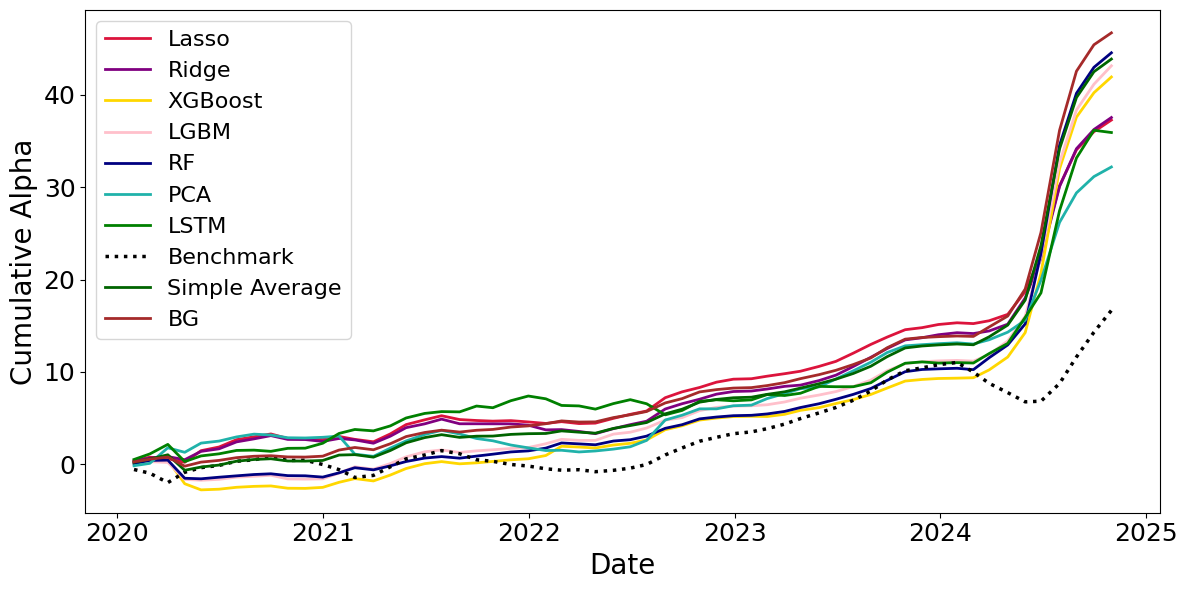

In [280]:
plot_cumulative_alpha(all_results_healthcare_clean, 'rolling_alpha_5f') # dashed - market rate; sample XGBoost

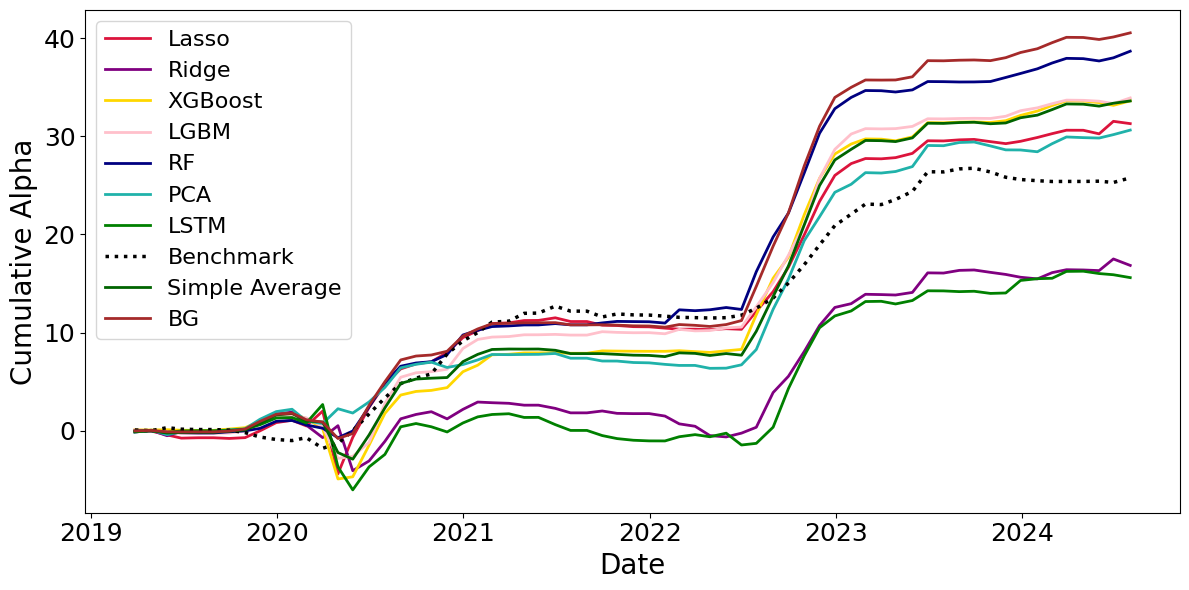

In [281]:
plot_cumulative_alpha(all_results_tech_clean, 'rolling_alpha_5f')